# This notebook shows an example of calculating and visualizing the RTV weekly coverage from the latest USWC real time vector product from [HFRnet THREDDS server](http://hfrnet-tds.ucsd.edu/thredds/catalog.html)

Call %matplotlib inline to have plots shown inline in the notebook

%matplotlib inline must be called before any other packages are imported

In [1]:
%matplotlib inline

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import colors,ticker
from cartopy import crs,feature

### Import Xarray package, which deals very well with NetCDF formatted data<br>Also import Pandas, which is a data analysis package<br>And scipy.ndimage for gaussian smoothing

In [3]:
import xarray as xr
import pandas as pd
import scipy.ndimage as ndimage
import datetime

### load 6km USWC RTV dataset through THREDDS <br>Some other datasets are shown as commented lines below
You must adjust your map parameters if you change regions

### instead of the NetCDF4 library, we will use xarray to read file from TDS


In [4]:
#USWC region
netcdf_data = xr.open_dataset('http://hfrnet-tds.ucsd.edu/thredds/dodsC/HFR/USWC/6km/hourly/RTV/HFRADAR_US_West_Coast_6km_Resolution_Hourly_RTV_best.ncd')
#netcdf_data = xr.open_dataset('http://hfrnet-tds.ucsd.edu/thredds/dodsC/HFR/USWC/1km/hourly/RTV/HFRADAR_US_West_Coast_1km_Resolution_Hourly_RTV_best.ncd')
#netcdf_data = xr.open_dataset('http://hfrnet-tds.ucsd.edu/thredds/dodsC/HFR/USWC/2km/hourly/RTV/HFRADAR_US_West_Coast_2km_Resolution_Hourly_RTV_best.ncd')

#USEGC region
#netcdf_data = xr.open_dataset('http://hfrnet-tds.ucsd.edu/thredds/dodsC/HFR/USEGC/6km/hourly/RTV/HFRADAR_US_East_and_Gulf_Coast_6km_Resolution_Hourly_RTV_best.ncd')
#netcdf_data = xr.open_dataset('http://hfrnet-tds.ucsd.edu/thredds/dodsC/HFR/USEGC/2km/hourly/RTV/HFRADAR_US_East_and_Gulf_Coast_2km_Resolution_Hourly_RTV_best.ncd')

### list variables and dimensions

In [5]:
netcdf_data

<xarray.Dataset>
Dimensions:       (lat: 367, lon: 234, nProcParam: 7, nSites: 52, time: 61687)
Coordinates:
  * lat           (lat) float32 30.25 30.30394 30.35788 ... 49.9381 49.99204
  * lon           (lon) float32 -130.36 -130.29753 ... -115.86803 -115.805565
  * time          (time) datetime64[ns] 2011-10-01 ... 2018-10-16T16:00:00
    time_run      (time) datetime64[ns] ...
Dimensions without coordinates: nProcParam, nSites
Data variables:
    site_lat      (nSites) float32 ...
    site_lon      (nSites) float32 ...
    site_code     (nSites) |S64 ...
    site_netCode  (nSites) |S64 ...
    procParams    (nProcParam) float32 ...
    time_offset   (time) datetime64[ns] ...
    u             (time, lat, lon) float32 ...
    v             (time, lat, lon) float32 ...
    DOPx          (time, lat, lon) float32 ...
    DOPy          (time, lat, lon) float32 ...
Attributes:
    netcdf_library_version:  4.1.3
    format_version:          HFRNet_1.0.0
    product_version:         HFRNet_

### Show variable information

In [6]:
print(netcdf_data.u)
print(netcdf_data.v)
print(netcdf_data.time.max())


<xarray.DataArray 'u' (time: 61687, lat: 367, lon: 234)>
[5297556186 values with dtype=float32]
Coordinates:
  * lat       (lat) float32 30.25 30.30394 30.35788 ... 49.9381 49.99204
  * lon       (lon) float32 -130.36 -130.29753 ... -115.86803 -115.805565
  * time      (time) datetime64[ns] 2011-10-01 ... 2018-10-16T16:00:00
    time_run  (time) datetime64[ns] ...
Attributes:
    units:                m s-1
    long_name:            surface_eastward_sea_water_velocity
    standard_name:        surface_eastward_sea_water_velocity
    ancillary_variables:  DOPx
    _ChunkSizes:          [  1 367 234]
<xarray.DataArray 'v' (time: 61687, lat: 367, lon: 234)>
[5297556186 values with dtype=float32]
Coordinates:
  * lat       (lat) float32 30.25 30.30394 30.35788 ... 49.9381 49.99204
  * lon       (lon) float32 -130.36 -130.29753 ... -115.86803 -115.805565
  * time      (time) datetime64[ns] 2011-10-01 ... 2018-10-16T16:00:00
    time_run  (time) datetime64[ns] ...
Attributes:
    units:     

### Grab lat, lon and time variables from dataset

In [7]:
time=netcdf_data.time

### Check geographic and time range of dataset

In [8]:
print("Geographic limits:",netcdf_data.lon.values.min(),netcdf_data.lon.values.max(),netcdf_data.lat.values.min(),netcdf_data.lat.values.max())
print("Dataset Start Time:",time.values.min())
print("Dataset End Time:",time.values.max())

Geographic limits: -130.36 -115.805565 30.25 49.99204
Dataset Start Time: 2011-10-01T00:00:00.000000000
Dataset End Time: 2018-10-16T16:00:00.000000000


### Set a time range for analysis<br>Use 7 days from latest observation

In [9]:
timeEnd=time.max()
timeStart=timeEnd-np.timedelta64(7,'D')

print("Analysis Start Time:",timeStart.values)
print("Analysis End Time:",timeEnd.values)

Analysis Start Time: 2018-10-09T16:00:00.000000000
Analysis End Time: 2018-10-16T16:00:00.000000000


### Set geographical limits for the map

In [38]:
latMax=39.5
latMin=32.5
lonMax=-117.18
lonMin=-127.20

### subset data using slices of time, lat and lon <br> Show values of dimensions<br>Note: as the size of the requests increases, it may be necessary to chunk data as TDS server may return partial records.<br>My experience shows me that the data size should be less than 55 Mb, but you may be able to get larger requests through without chunking

In [39]:
data=netcdf_data.sel(time=slice(timeStart,timeEnd),lat=slice(latMin,latMax),lon=slice(lonMin,lonMax))
#data=netcdf_data.sel(time=slice(timeStart,timeEnd))

print(dict(data.dims))
data.nbytes/1024/1024

{'lat': 130, 'lon': 160, 'nProcParam': 7, 'nSites': 52, 'time': 169}


53.64944076538086

### calculate the percent coverage of the RTV data<br>If the minimum of totalCount is greater than zero, it is likely the request wasn't processed completely

In [40]:
# count number of observations
totalCount=data.u.count('time')
totalCount.min()

<xarray.DataArray 'u' ()>
array(0)

In [41]:
# find grid
lon,lat=np.meshgrid(totalCount.lon.values,totalCount.lat.values)

# mask out 0s
mask=totalCount==0


In [42]:
# calculate percent coverage from totalCount
percentCoverage=np.ceil((totalCount.values/data.time.size)*100)

# Smooth with gaussian filter
Z2 = ndimage.gaussian_filter(totalCount.values,sigma=1)

# calculate percent coverage from smoothed count
percentCoverage_smooth=np.ceil((Z2/data.time.size)*100)

# find the points where the count is greater than 1
tc=totalCount.to_dataframe()
goodGrid=tc[tc.u>1].reset_index() 

### Plot RTV Coverage

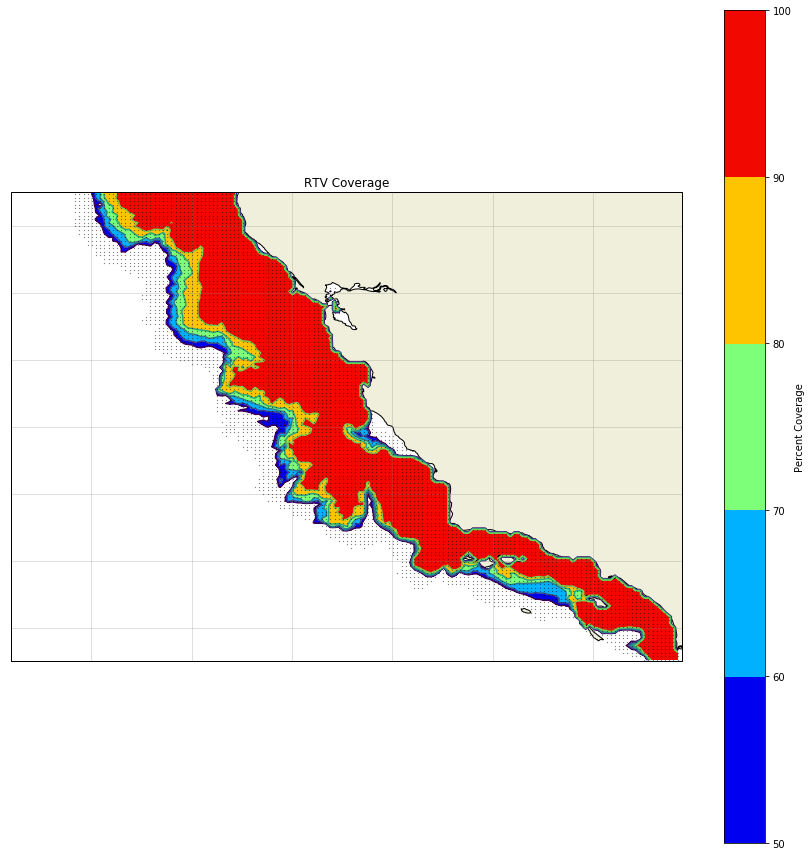

In [43]:
fig=plt.figure(figsize=(12,12))
ax = plt.axes(projection=crs.PlateCarree())
ax.gridlines(linewidth=.5, color='gray', alpha=0.5, linestyle='-')

ax.set_title('RTV Coverage')
ax.set_extent([lonMin,lonMax,latMin,latMax])
CF=ax.contourf(lon,lat,percentCoverage,[50,60,70,80,90,100],cmap='jet')
ax.contour(lon,lat,percentCoverage,[50,60,70,80,90,100])
ax.plot(goodGrid.lon,goodGrid.lat,'.',markersize=.4,color='black')

ax.add_feature(feature.NaturalEarthFeature('physical', 'land', '10m', edgecolor='face',facecolor=feature.COLORS['land']))
plt.colorbar(CF,label="Percent Coverage")
ax.coastlines(resolution='10m',color='k')
plt.tight_layout()

### Plot the smoothed RTV coverage

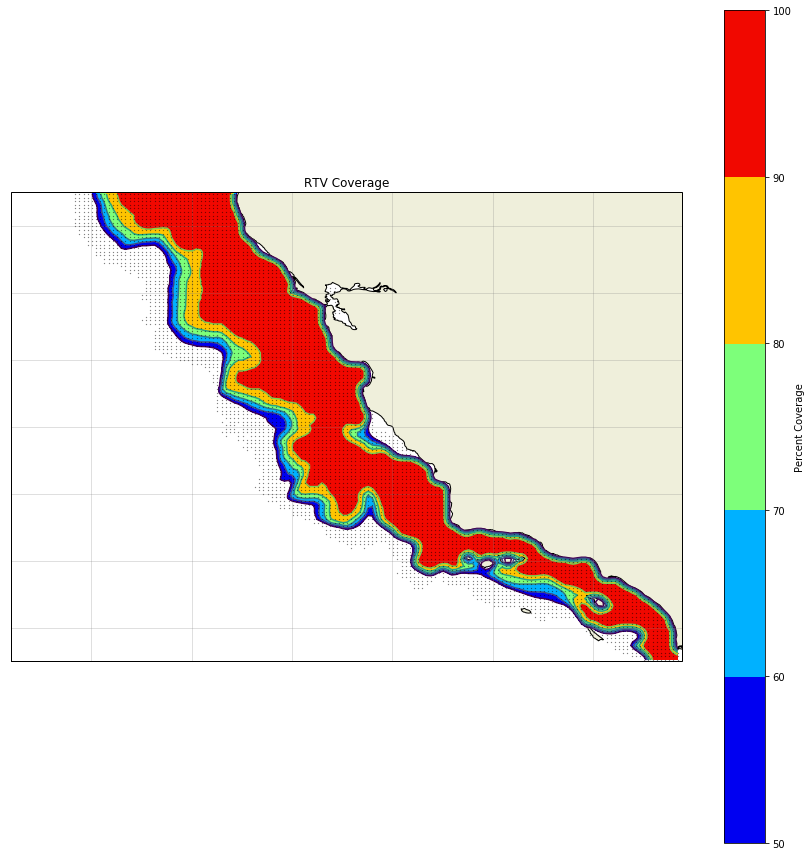

In [44]:
fig=plt.figure(figsize=(12,12))
ax = plt.axes(projection=crs.PlateCarree())
ax.gridlines(linewidth=.5, color='gray', alpha=0.5, linestyle='-')

ax.set_title('RTV Coverage')
ax.set_extent([lonMin,lonMax,latMin,latMax])
CF=ax.contourf(lon,lat,percentCoverage_smooth,[50,60,70,80,90,100],cmap='jet')
ax.contour(lon,lat,percentCoverage_smooth,[50,60,70,80,90,100])
ax.plot(goodGrid.lon,goodGrid.lat,'.',markersize=.4,color='black')

ax.add_feature(feature.NaturalEarthFeature('physical', 'land', '10m', edgecolor='face',facecolor=feature.COLORS['land']))
plt.colorbar(CF,label="Percent Coverage")
ax.coastlines(resolution='10m',color='k')
plt.tight_layout()